# **Computer Vision - Assignment 3 - IMAGE REGISTRATION USING HOMOGRAPHIES**
#### Value: 10 (+4) points | Due date: December 22 23:59 | Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: JESÚS MIGUEL ROJAS GÓMEZ


In this assignment you will learn:

a) How to detect relevant regions using the Harris's algorithm.

b) How to detect matches between images using SIFT descriptors.

c) How to compose a mosaic from a bunch of images. 

## Normas de entrega

Para este trabajo, al igual que para los demás, se deben presentar  las valoraciones y decisiones adoptadas en cada uno de los apartados. También deberá incluirse una valoración sobre la calidad de los resultados obtenidos. Se recuerda que código sin informe explicativo no puntúa.

Para poder evaluar el BONUS se debe obtener al menos el 70% de los puntos de la parte obligatoria

Normas de entrega (EL INCUMPLIMIENTO DE ESTAS NORMAS SIGNIFICA PÉRDIDA DIRECTA DE 1 PUNTO CADA VEZ QUE SE DETECTE UN INCUMPLIMIENTO):

1. El diseño de celdas del documento debe ser respetado.
2. Solo se entregará el código fuente (fichero .ipynb, y ficheros auxiliares externos: P0.py y P1.py) y no se enviarán las imágenes empleadas.
3. Los path que se usen en la lectura de imágenes o cualquier otro fichero de entrada debe ser siempre “/content/drive/My Drive/images/nombre_fichero”
4. El código deberá  presentarse junto con los resultados obtenidos en cada apartado y los  correspondientes comentarios, explicaciones y valoraciones.  Recuerde que la entrega de código sin informe explicativo o valoraciones no puntúa.

The next cell is intended to install an upgrade of the OpenCV package that includes the SIFT algorithm. After the installation, the  python-kernel (restart runtime) has to be restarted to import the new release.

In [1]:
import sys, cv2
(major, minor,_)=cv2.__version__.split(".")
if int(minor) < 5:
  if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())

print(cv2.__version__)

4.6.0


This cell sets the environment and imports your packages

In [2]:
# Let's start importing all background modules
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
# change directory
%cd '/content/drive/My Drive'
# Let's import the python module exercises.py  to have access to its functions and Classes
path_to_module='/content/drive/My Drive/CV/'
sys.path.append(os.path.abspath(path_to_module))
import P0,P1
get_image = lambda route: os.path.join('/content/drive/My Drive/images/', route)
import numpy as np
from matplotlib import pyplot as plt

Mounted at /content/drive
/content/drive/My Drive


# **Exercise 1:** Harris detector and non-maxima suppresion (3 points)

Write Python code to implement the detection of the strongest 100-150 Harris points in an image, and show your results using the function cv2.drawKeyPoints(). You can apply OpenCV's functions getDerivKernels() and sepFilter2D(). However, those who use their own code from P1 (for computing the derivatives) could have a bonus of +1 point. 

Hint (use different cells for the items):\
a) Fix the derivative and integration scales. Try first sigma values in the range 1-3.\
b) Compute the derivative images. \
c) Compute the three terms of the second moment matrix (SMM) at each pixel. To do it, apply the convolution with a Gaussian mask of size the integration area. \
d) Compute the Harris value at each pixel (discard the points close to the edges).\
e) Apply Non-Maxima Suppression by using the function corner_peaks() from the module skimage.features. The student must set the minimum distace between maxima. The output will be a list of (x,y) coordinates.  Extract the values in these coordinates and create a list of vectors (x,y,value).\
f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma (sigma=3) and computing the orientation of the gradient at those points.\
d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including (x,y,scale,orientation).\
e) Draw the keypoints on the image using the function cv2.drawKeypoints().


En primer lugar, calculamos las derivadas usando las funciones creadas en la práctica 1. Para ello, definiremos la función `derivatives`, que acepta como entrada una imagen `im` y una valor de sigma `sigmaD`, y devuelve la derivada de primer orden de la imagen aplicando el valor de sigma proporcionado. Una vez realizada la función, podemos calcular el Harris Map. Para ello, definiremos la función `HarrisMap` que acepta como parámetros las derivadas `dx` y `dy`, y `sigmaI`, y calcula el HarrisMap.

In [3]:
# Compute image derivatives
def derivatives(im,sigmaD):
  dx,dy = P1.gradientIM(im,sigmaD)
  return dx,dy

# Compute Harris-criterium Map
def HarrisMap(dx,dy,sigmaI):
  # Compute the three terms of the SMM at each pixel and he map values
  p00 = P1.my2DConv(dx*dx,sigmaI,[0,0])
  p11 = P1.my2DConv(dy*dy,sigmaI,[0,0])
  p01 = P1.my2DConv(dx*dy,sigmaI,[0,0])
  p10 = p01

  det = p00*p11-p01*p10
  tr = p00+p11
  
  HMap = det/tr

  return HMap

The following cell implements the Non-Maxima-Suppression stage. This function calls the corner_peaks() function from the skimage.feature package (see below). This function returns the local maxima sorted by value.

Implementamos ahora la selección de puntos a partir de un umbral dado. Para ello, definiremos la función `NonMaximaSupression` que acepta como parámetros el Harris Map `harrisMap` calculado en la función anterior, la distancia mínima `min_distance` y el valor umbral `threshold`, y que apoyándonos de la función `corner_peaks` devuelve pares de puntos y el valor de dichos puntos.

In [4]:
def NonMaximaSuppression(harrisMap, min_distance, threshold):
  points = corner_peaks(harrisMap, min_distance)
  # check the order
  values=[]
  coord=[]
  
  for p in points:
    if harrisMap[p[0],p[1]] >= threshold:
      coord.append(p)
      values.append(harrisMap[p[0],p[1]])

  return coord, values


Orientation is computed as the angle of the gradient after smoothing the derivative images with a Gaussian (with sigma=3).

A KeyPoint is an OpenCV's structure, associated to each detected region,  necessary to call OpenCV feature extraction algorithms. You have to create one KeyPoint structure per detected region with information about (location, scale,orientation). (See the OpenCV documentation for more information)

Calculamos ahora la orientación y los keyPoints. Para la orientación, definiremos la función `orientation` que acepta como entrada el valor de las derivadas y calcula la orientación. Para los keyPoints, definiremos la función `keyPoints`, que acepta como parámetros las coordenadas `coord`, la orientación `theta` y el número de keyPoints `size` y devuelve los keyPoints calculados.

In [5]:
# compute the orientation map
def orientation(dx,dy):
  # Let's compute  orientation in degrees
  dy = P1.my2DConv(dy,3,[0,0])
  dx = P1.my2DConv(dx,3,[0,0])

  theta = np.arctan2(dy,dx)*180/np.pi
  return theta

# Create the KeyPoint list from the information about locations, orientations and scale 
# keyPoint=KeyPoint(x_float, y_float, scale_float,orientation_float), in Harris scale=1
# 
def keyPoints(coord,theta,size):
  keyPoints = []

  for i,p in zip(range(size),coord):
    # IMPORTANTE! AQUI LE HE DADO LA VUELTA A X E Y PORQUE LO IMPRIMIA INVERTIDO
    aux = cv2.KeyPoint(x=float(p[1]),y=float(p[0]),size=1,angle=theta[p[0],p[1]])
    keyPoints.append(aux)

  return(keyPoints)
  

The following cell computes the Harris KeyPoints detection (calling to the previously implemented functions, like derivatives(), HarrisMap(), NonMaximaSuppression(), orientation() and keyPoints()), and displays them on the image. Use the function cv2.drawKeypoints() with flags, cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS.

Una vez definido estas funciones, inicializamos los parámetros necesarios e imprimimos la imagen junto a los keypoints.

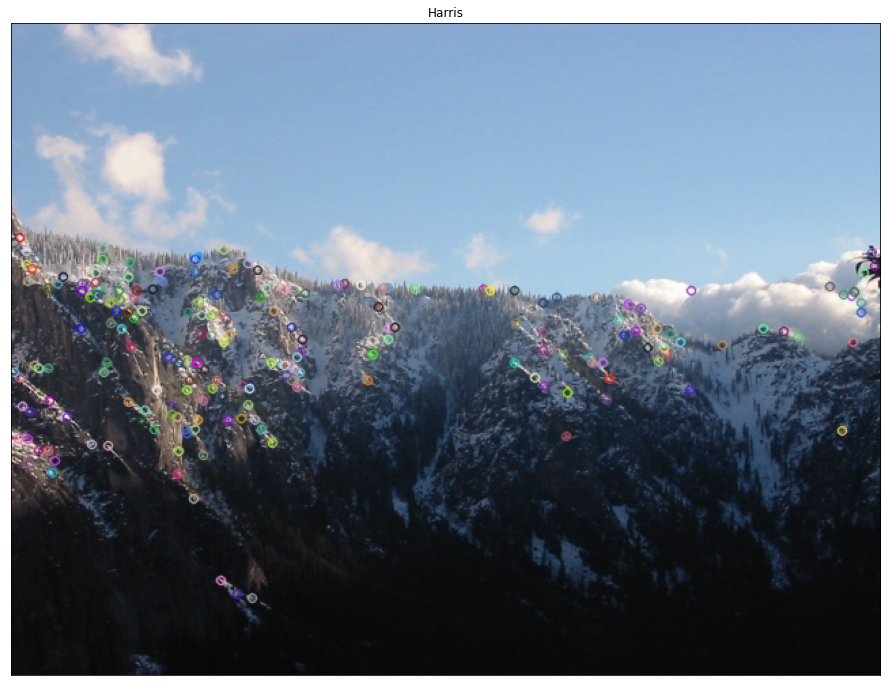

In [6]:
# Let's compute the KeyPoints-Harris and display them
#
from skimage.feature import corner_peaks
img=P0.readIm(get_image('yosemite7.jpg'),0).astype(np.float64)
#
# parameters
sigmaD = 1.5
sigmaI = 1.5*sigmaD
# este parametro no se usa
sizeIMask=np.ceil(6*sigmaI)+1
min_distance=1
Threshold_MINVALUE=1
#
dx,dy = derivatives(img,sigmaD)
HM = HarrisMap(dx,dy,sigmaI)
coord,values = NonMaximaSuppression(HM,min_distance,threshold=Threshold_MINVALUE)
theta = orientation(dx,dy)
#
keypoints=keyPoints(coord,theta,200)
# POR ALGUNA RAZON ESTO NO VA, PREGUNTAR DUDA
im = cv2.cvtColor(P0.readIm(get_image('yosemite7.jpg'),1), cv2.COLOR_BGR2RGB)
img=cv2.drawKeypoints(im,keypoints,cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# PARECE QUE ESTAN ROTADOS LOS PUNTOS
P0.displayIm(img,factor=3,title='Harris')

Podemos comprobar en la imagen que los puntos señalados corresponden con los picos de las montañas, como cabría esperar.

# **Exercise 2:** Matching keypoints between images using SIFT descriptors (2 points)

Write Python code to compute the matching between points from two images. To do so apply the SIFT algorithm to extract points and descriptors in both images.  Use the Force-Brute cross-check criteria and the KNN one to compute matches, and draw the matches between images using the function cv2.drawMatches(). 

En primer lugar, definimos la función `siftPoints` que calcula mediante el algoritmo SIFT los keyPoints y los descriptores, dando como entrada una imagen `im` y el número de características `nfeatures`.

In [7]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(im,nfeatures=5000):
  sift=cv2.SIFT_create(nfeatures)
  kp,ds = sift.detectAndCompute(im,None)
  return kp,ds

In OpenCV the output of a matching process is a vector of matches. Each match provides information about the indexes of the matched KeyPoints and the distance between them.

Definimos ahora tres funciones, una para mostrar los keyPoints apoyándonos en la función `drawKeypoints` de OpenCV, otra para mostrar los matches entre dos imágenes apoyándonos en las funciones `drawMatches` y `drawMatchesKnn` de OpenCV, y la última que calcula estos matches dependiendo del `flagMode` aportado como parámetro; si es 'BF', calculamos los matches aplicando fuerza bruta, si es 'KNN', calculamos los matches aplicando el algoritmo KNN, apoyándonos en la función `BFMatcher_create` de OpenCV.

In [8]:
# This function display the KeyPoints of an image
def showKP(im,kp,title):
  output = cv2.drawKeypoints(im,kp,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  P0.displayIm(output, title, factor=2)

# This function display the matches between two images
def showMatches(im1,kp1,im2,kp2,matches, N, title='Matches'):
  if N == 'BF':
    output = cv2.drawMatches(im1,kp1,im2,kp2,matches,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  else:
    output = cv2.drawMatchesKnn(im1,kp1,im2,kp2,matches,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  P0.displayIm(output, title, factor=3)

#This function compute matches between descriptors of two images
def matching(ds1,ds2,FlagMode='BF'):
  if FlagMode=='BF':
    bf=cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    matches = bf.match(ds1,ds2)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    return matches
  elif FlagMode=='KNN':
    bf = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(ds1,ds2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append([m])
    return good
  else:
    return print('Error in Matching mode')
  

Now check your functions about KeyPoints and matching. To do so, read two consecutive images, let say Yosemite1 and Yosemite2, and show and analyze the results obtained.

In [9]:
# Here we check our functions 
img1=P0.readIm(get_image('yosemite1.jpg'),1)
im1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2=P0.readIm(get_image('yosemite2.jpg'),1)
im2=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

# let's compute points and descriptors
kp1,ds1 = siftPoints(im1,nfeatures=300)
kp2,ds2 = siftPoints(im2,nfeatures=300)
showKP(img1,kp1,title='image 1')
showKP(img2,kp2,title='image 2')

flagMode = 'BF'
matches=matching(ds1,ds2,flagMode)
showMatches(img1,kp1,img2,kp2,matches,flagMode,title='Matches BF')
flagMode = 'KNN'
matches=matching(ds1,ds2,flagMode)
showMatches(img1,kp1,img2,kp2,matches,flagMode,title='Matches KNN')


Output hidden; open in https://colab.research.google.com to view.

Podemos comprobar en los resultados que, en fuerza bruta, en los puntos comunes a ambas imágenes, los matches si son correctos. Sin embargo, en los puntos que no son comunes a ambas imágenes podemos comprobar que existen outliers. Por otro lado, con knn, podemos ver que el resultado es muchísimo mejor, estando todas las correspondencias que calcula correctas.

# **Exercise 3.A:** Homographies calculation (1 point)

Now you are ready to calculate the homographies. To calculate the homography between two images call the function cv2.findHomography(), which takes as input the lists of located KeyPoints (in both images) and the matches found between them. Use RANSAC to perform a robust estimation.

En primer lugar, definiremos una función `homography` que dados los keypoints de dos imágenes `kp1` y `kp2`, los matches `matches`, el error `Ransac_Error` y el número mínimo de matches `MIN_MATCH_COUNT` calcula la homografía, apoyándonos en la función `findHomography` de OpenCV.

In [10]:
# this function computes a homography
def homography(kp1,kp2,matches, Ransac_Error,MIN_MATCH_COUNT=20):
  # the order is important
  if len(matches)>MIN_MATCH_COUNT:
    # Let's extract two lists of points in correspondences from matches
    src_pts=[]
    dst_pts=[]
    for m in matches:
      src_pts.append(kp1[m.queryIdx].pt) 
      dst_pts.append(kp2[m.trainIdx].pt)
    src_pts=np.array(src_pts)#.reshape(-1,1,2)
    dst_pts=np.array(dst_pts)#.reshape(-1,1,2)
    # before changing parameter values, try first the opencv by default.
    H, mask = cv2.findHomography(src_pts,dst_pts,Ransac_Error)
    #print('Inliers:', sum(mask))
  else:
    H = None
    print('Error - very few matches')
  return H

# **Exercise 3.B:** Building a mosaic (4 points)


To compose a mosaic we will need to set several pieces of information. \
a) The size of the canvas according to the number of images to be stitched and their dimensions.\
b) The central image that will give the axes to the mosaic.\
c) The order of each image with respect to the central one.\
d) The homography to copy the central image into the canvas.

Here is the guideline to compute a lineal Mosaic:\
a) Read the images in the order left-right of the camera.\
b) Set one central image as the reference to give axes to the canvas.\
c) Compute the homography between each two consecutive images in your list.\
d) Set the canvas and the reference homography.\
e) Compute the homography between each image and the canvas.\
f) Use  the function cv2.warpPerspective() to transport the images to the canvas using the computed homographies.\
g) Remove redundant black-pixels.



En primer lugar, calculamos las homografías entre imágenes consecutivas. Después, calculamos las homografías de las imágenes al canvas. Y por último, fijamos la homografía de la imagen central al canvas.

In [11]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images):
  H=[]
  Ransac_Error=cv2.RANSAC
  for item in range(0,len(images)-1):
    kp1,ds1=siftPoints(images[item],nfeatures=500)
    kp2,ds2=siftPoints(images[item+1],nfeatures=500)
    matches=matching(ds1,ds2,FlagMode='BF')
    Haux=homography(kp1,kp2,matches,Ransac_Error,MIN_MATCH_COUNT=20)
    H.append(Haux)
    #print(Haux)
  return H

# this function computes the homography from each image to the canvas
def mosaicHomographies(H,idx):
  # idx is the index of the reference image
  # invert homographies
  for item in range(idx,len(H)):
    H[item] = inv(H[item])
  # compute homographies by compositoon
  for item in range(idx-2,-1,-1):
    H[item] = np.matmul(H[item+1],H[item])
  for item in range(idx+1,len(images)-1,1):
    H[item] = np.matmul(H[item-1],H[item])
  return H

# this function fixes the homography from the central image to the canvas
# others definitions are possible
def axesHomography(nim,sizeim,sizecanvas):
  H=np.eye(3)
  H[0,2]=sizecanvas[1]//2-sizeim[1]//2
  H[1,2]=sizecanvas[0]//2-sizeim[0]//2
  return H

Una vez definidas las funciones anteriores, apoyándonos de la función `warpPerspective` de OpenCV calculamos el mosaico según las instrucciones definidas en esta plantilla.

In [12]:
# Auxiliary functions
# this function defines and return the canvas
def setCanvas(row,col,flagColor,nim=2):
  rows=row*nim
  cols=col*nim
  if flagColor==3:
    return np.zeros((rows,cols,3),dtype=np.uint8)
  else:
    return np.zeros((rows,cols),dtype=np.uint8)

# This function removes the redundant black-pixels from the canvas
def blackOut(img):
  if len(img.shape)==3:
    im =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w,:]
  else:
    mask = np.array((img > 0), np.uint8) 
    x,y,w,h=cv2.boundingRect(mask)
    return img[y:y+h,x:x+w]
  
# this function composes the mosaic from the extremes to the center
# transporting each image with its homography
def composeMosaic(images,canvas,H,idxc,H0,flagAffinity):
  rows=canvas.shape[0]
  cols=canvas.shape[1]
  nH=0
  # global composition
  for nim in range(0,idxc):
    if nim == idxc:
      print('nim=',nim,'nH=',0)
      Haux=H0
    else:
      print('nim=',nim,'nH=',nH)
      Haux=np.matmul(H0,H[nH])
      nH=nH+1
    #print(Haux/Haux[2,2])
    canvas=cv2.warpPerspective(images[nim],Haux, [cols,rows], dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    #P0.displayIm(blackOut(canvas),'',3)
  nH=len(H)-1

  for nim in range(len(images)-1,idxc-1,-1):
    if nim == idxc:
      print('nim=',nim,'nH=',0)
      Haux=H0
    else:
      print('nim=',nim,'nH=',nH)
      Haux=np.matmul(H0,H[nH])
      nH=nH-1
    #print(Haux/Haux[2,2])
    canvas=cv2.warpPerspective(images[nim], Haux, [cols,rows], dst=canvas, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_TRANSPARENT)
    #P0.displayIm(blackOut(canvas),'',3)
  return canvas


The next cell contains the mosaic catalog with 5 possible scenarios: 

- EXAMPLE 1 (rectangular projection with 4 Yosemite images) (2 points)

- EXAMPLE 2 (rectangular projection with 8 corridor images) (3 points)

- EXAMPLE 3 (rectangular projection with 10 office images) (4 points)

- EXAMPLE 4 (14 images of Granada/Alhambra, mainly for spherical projection; see Bonus)

- EXAMPLE 5 (14 images of Sierra Nevada, mainly for spherical projection; see Bonus)

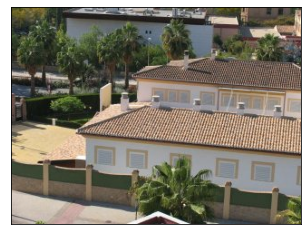

In [13]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=3
images = []

#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  PREFIX=''
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  PREFIX='corridor/'
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
    PREFIX='despacho/'
    nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
            'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
    for item in nameImages:
      im = P0.readIm(get_image(PREFIX+item),flagColor=1)
      images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='SierraNevada/IMG_20220312_1029'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
else:
  print('Error - no such Mosaic')
  #break

Rectangular projection: The target is example-3. Example 1 and 2 are also possible but you get a lower mark (see the mosaic catalog). You must use all images.

read images 10
idxc 5
nim= 0 nH= 0
nim= 1 nH= 1
nim= 2 nH= 2
nim= 3 nH= 3
nim= 4 nH= 4
nim= 9 nH= 8
nim= 8 nH= 7
nim= 7 nH= 6
nim= 6 nH= 5
nim= 5 nH= 0


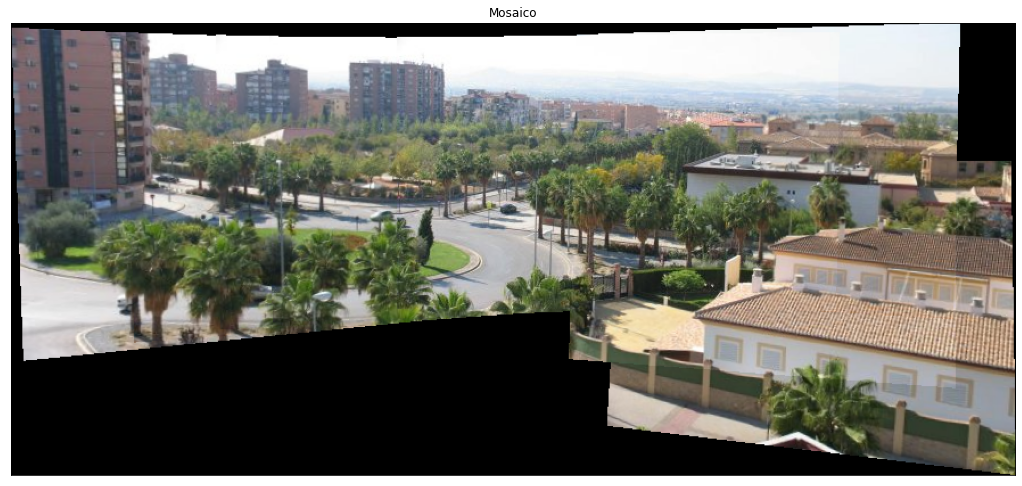

In [14]:
from numpy.linalg import inv
# 
flagSpherical=False  # 
if flagSpherical:
  images=SphericalProjection(images)
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images),images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc)
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)
P0.displayIm(blackOut(mosaic),'Mosaico',3)

Como podemos comprobar, el mosaico se ha construido correctamente. La presencia de píxeles negros en la esquina inferior izquierda y en la esquina superior derecha es debido a un cambio en la altura de la camara al realizar las fotos.

# **BONUS**: Spherical projection.  (3 points)
Use Examples 4 or 5's images and show the case f=500. You must use all images.

Para realizar la proyección esférica, calculamos las coordenadas según hemos visto en las diapositivas de clase, y simplemente convertimos la lista de imágenes rectángulares en imágenes esféricas, llamando a las funciones definidas; primero usando la función `remap` de OpenCV con interpolación cúbica para calcular las coordenadas esféricas de la imagen, y luego recortando `cutpix` arriba y abajo, izquierda y derecha de cada imagen. El resto es calcular la proyección del mismo modo que calculamos la proyección rectangular.

In [15]:
def spherical_lookupTable (f,imsize):
  # Here we compute the spherical coordinates where the image pixel project.
  # A sphere of radius r=f is fixed.
  # Begin by discretizing the azimuth and elevation ranges according to the image size and the focal length fixed. 
  # Then compute the coordinates on the sphere for each couple of angle-values ( azimuth and elevation)
  # return the computed coordinates
  # Slides and Szeliski's book equations will help
  
  #azim_range = np.linspace(-np.pi,np.pi,imsize[0])
  #el_range = np.linspace(-np.pi/2,np.pi/2,imsize[1])
  azim_range = np.linspace(0,imsize[0],num=imsize[0])
  el_range = np.linspace(0,imsize[1],num=imsize[1])
  xc = imsize[0]/2
  yc = imsize[1]/2

  azim,el = np.meshgrid(azim_range,el_range)

  theta = (azim-xc)/f
  phi = (el-yc)/f

  x_ = np.sin(theta)*np.cos(phi)
  y_ = np.sin(phi)
  z_ = np.cos(theta)*np.cos(phi)

  x = f*x_/z_+xc
  y = f*y_/z_+yc

  return x.astype(np.float32),y.astype(np.float32)

def sphericalTrim(images,cutPix):
  # here we eliminate by left and right, above and below each image the number the
  # lines indicates in cutPix=[#row,#column]
  resultImages = []
  for image in images:
    rows = image.shape[0]
    columns = image.shape[1]
    rowStart = cutPix[0]
    rowEnd = rows - cutPix[0]
    columnStart = cutPix[1]
    columnEnd = columns - cutPix[1]
    trimmedImage = image[rowStart:rowEnd,columnStart:columnEnd]
    resultImages.append(trimmedImage)

  return resultImages

def sphericalProjection(images,f,cutpix):
  # Here we interpolate a rectangular mesh of values from the  projection of the pixels.
  # images: set of images; f: focal length; cutpix: #row and #column to remove

  sphim=[]

  for item in images:
    x,y = spherical_lookupTable(f,item.shape)
    sphim.append(cv2.remap(item,x,y,interpolation=cv2.INTER_CUBIC))
  
  # after projection images must be trimmed
  sphim = sphericalTrim(sphim, cutpix)
  
  return sphim  # vector of projected images

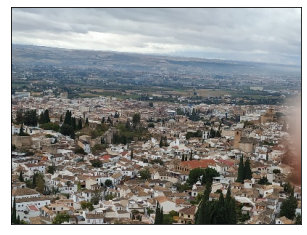

In [16]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=4
images = []

if mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='SierraNevada/IMG_20220312_1029'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
else:
  print('Error - no such Mosaic')
  #break

read images 14
idxc 7
nim= 0 nH= 0
nim= 1 nH= 1
nim= 2 nH= 2
nim= 3 nH= 3
nim= 4 nH= 4
nim= 5 nH= 5
nim= 6 nH= 6
nim= 13 nH= 12
nim= 12 nH= 11
nim= 11 nH= 10
nim= 10 nH= 9
nim= 9 nH= 8
nim= 8 nH= 7
nim= 7 nH= 0


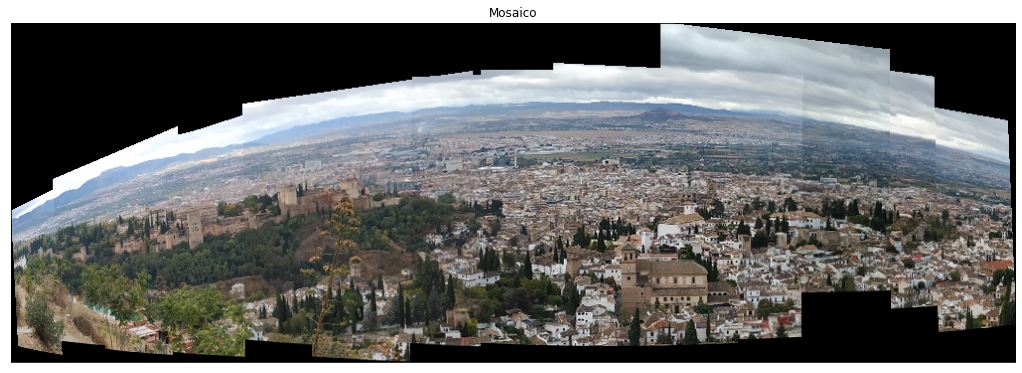

In [17]:
from numpy.linalg import inv
# 
flagSpherical=True  # 
if flagSpherical:
  images=sphericalProjection(images,f=500,cutpix=(20,20))
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images),images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc)
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)
P0.displayIm(blackOut(mosaic),'Mosaico',3)

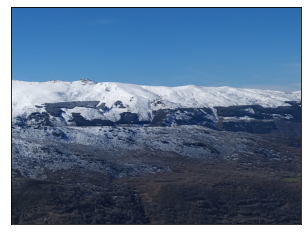

In [18]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=5
images = []

if mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='SierraNevada/IMG_20220312_1029'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
else:
  print('Error - no such Mosaic')
  #break

read images 14
idxc 7
nim= 0 nH= 0
nim= 1 nH= 1
nim= 2 nH= 2
nim= 3 nH= 3
nim= 4 nH= 4
nim= 5 nH= 5
nim= 6 nH= 6
nim= 13 nH= 12
nim= 12 nH= 11
nim= 11 nH= 10
nim= 10 nH= 9
nim= 9 nH= 8
nim= 8 nH= 7
nim= 7 nH= 0


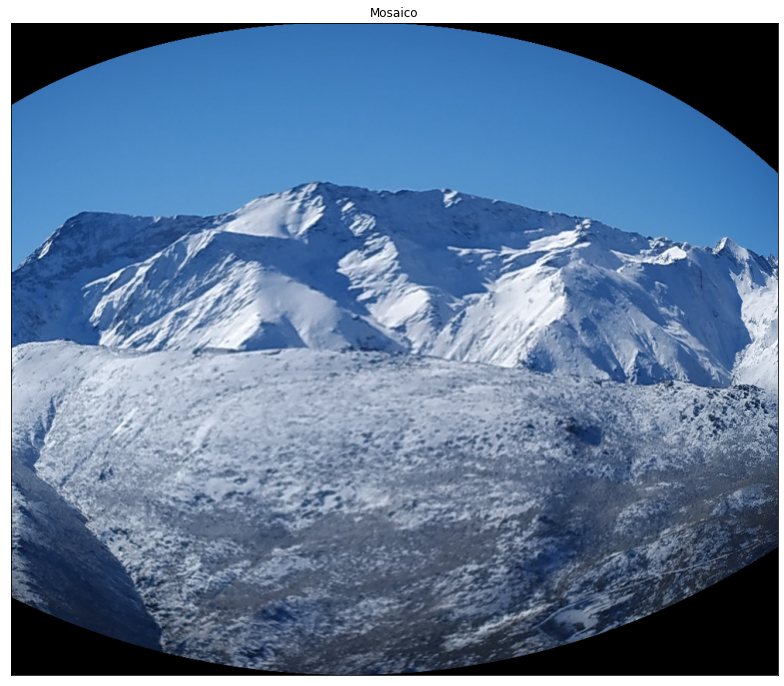

In [19]:
from numpy.linalg import inv
# 
flagSpherical=True  # 
if flagSpherical:
  images=sphericalProjection(images,f=500,cutpix=(20,20))
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images),images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc)
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)
P0.displayIm(blackOut(mosaic),'Mosaico',3)

Como podemos ver en los mosaicos construidos, el resultado es bastante bueno y de mejor calidad al usar proyección esférica en lugar de proyección rectángular.

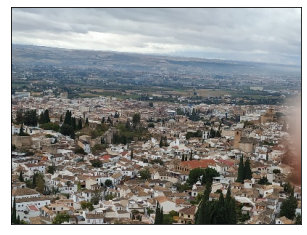

In [20]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=4
images = []

#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  PREFIX=''
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  PREFIX='corridor/'
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
    PREFIX='despacho/'
    nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
            'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
    for item in nameImages:
      im = P0.readIm(get_image(PREFIX+item),flagColor=1)
      images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='SierraNevada/IMG_20220312_1029'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
else:
  print('Error - no such Mosaic')
  #break

read images 14
idxc 7
nim= 0 nH= 0
nim= 1 nH= 1
nim= 2 nH= 2
nim= 3 nH= 3
nim= 4 nH= 4
nim= 5 nH= 5
nim= 6 nH= 6
nim= 13 nH= 12
nim= 12 nH= 11
nim= 11 nH= 10
nim= 10 nH= 9
nim= 9 nH= 8
nim= 8 nH= 7
nim= 7 nH= 0


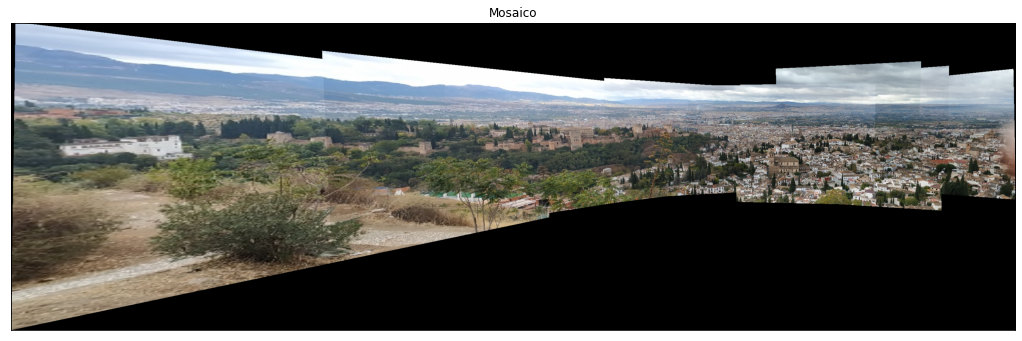

In [21]:
from numpy.linalg import inv
# 
flagSpherical=False  # 
if flagSpherical:
  images=sphericalProjection(images,f=500,cutpix=(20,20))
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images),images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc)
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)
P0.displayIm(blackOut(mosaic),'Mosaico',3)

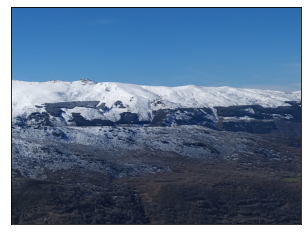

In [22]:
# CATALOG OF MOSAIC

# Mosaic construction: All of them are Left-Right camera motion

mosaicIndex=5
images = []

#EXAMPLE:1 (easy, for rectangular projection) (2 points)
if mosaicIndex==1: 
  PREFIX=''
  nameImages=['yosemite1.jpg','yosemite2.jpg','yosemite3.jpg','yosemite4.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
  
# EXAMPLE-2 (rectangular projection, tricky in a couple of homographies) (3 points)
elif mosaicIndex==2:
  PREFIX='corridor/'
  nameImages=['Picture1.jpg','Picture2.jpg','Picture3.jpg','Picture4.jpg','Picture5.jpg','Picture6.jpg','Picture7.jpg','Picture8.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-3 (rectangular projection) (4 points)
elif mosaicIndex==3:
    PREFIX='despacho/'
    nameImages=['mosaico002.jpg','mosaico003.jpg','mosaico004.jpg','mosaico005.jpg','mosaico006.jpg',
            'mosaico007.jpg','mosaico008.jpg','mosaico009.jpg','mosaico010.jpg','mosaico011.jpg']
    for item in nameImages:
      im = P0.readIm(get_image(PREFIX+item),flagColor=1)
      images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-4 (mainly for spherical projection)
elif mosaicIndex==4:
  PREFIX='Granada/IMG_20211030_1104'
  nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

# EXAMPLE-5 (mainly for spherical projection)
elif mosaicIndex==5:
  PREFIX='SierraNevada/IMG_20220312_1029'
  nameImages=['31_S.jpg','32_S.jpg','34_S.jpg','37_S.jpg','40_S.jpg','42_S.jpg',
            '44_S.jpg','46_S.jpg','48_S.jpg','50_S.jpg','51_S.jpg','54_S.jpg',
            '57_S.jpg','58_S.jpg'] 
  for item in nameImages:
    im = P0.readIm(get_image(PREFIX+item),flagColor=1)
    images.append(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
else:
  print('Error - no such Mosaic')
  #break

read images 14
idxc 7
nim= 0 nH= 0
nim= 1 nH= 1
nim= 2 nH= 2
nim= 3 nH= 3
nim= 4 nH= 4
nim= 5 nH= 5
nim= 6 nH= 6
nim= 13 nH= 12
nim= 12 nH= 11
nim= 11 nH= 10
nim= 10 nH= 9
nim= 9 nH= 8
nim= 8 nH= 7
nim= 7 nH= 0


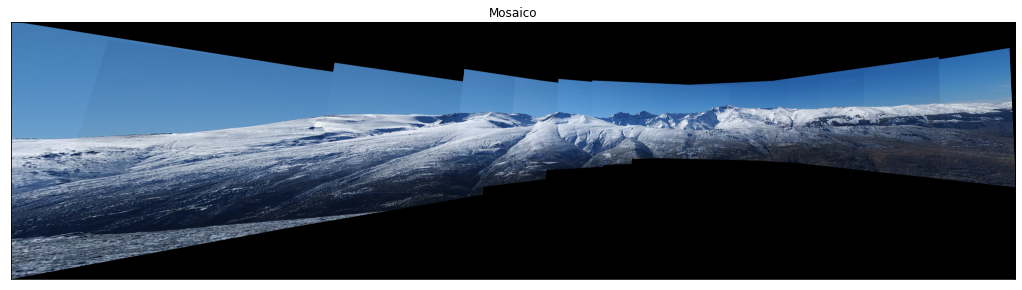

In [23]:
from numpy.linalg import inv
# 
flagSpherical=False  # 
if flagSpherical:
  images=sphericalProjection(images,f=500,cutpix=(20,20))
print('read images',len(images))
# Set the central image 
idxc=int(len(images)/2)
print('idxc',idxc)
# Compute local homographies beetwen images
H=computeLocalHomographies(images)
# Set the canvas
canvas=setCanvas(images[idxc].shape[0], images[idxc].shape[1], len(images[idxc].shape), len(images))
# Compute the homography given axis to the canvas
H0=axesHomography(len(images),images[idxc].shape, canvas.shape)
# Compute the homographies between images and the canvas
H=mosaicHomographies(H, idxc)
# Compose the mosaic transporting the images into the canvas
mosaic= composeMosaic(images, canvas, H, idxc, H0, None)
P0.displayIm(blackOut(mosaic),'Mosaico',3)